In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import figure
from itertools import combinations
from scipy.special import rel_entr

from skbio.diversity import alpha_diversity, beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim, mantel
from skbio import DistanceMatrix
from skbio.tree import TreeNode
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
## helper functions
    
def print_n(grouped_df, groupby):
    '''
    Print out n for each value in the [groupby] column of [grouped_df]
    '''
    for val in set(grouped_df[groupby]):
        count = len(grouped_df[grouped_df[groupby] == val])
        print(f"{val}: {count}") 

def group_KL_div(df, groupby_col):
    '''
    Calculate diversity within a group for each val in groupby_col
    Score = mean of KL divergence from group mean.
    '''
    avg_KL_list = []
    for group in df[groupby_col].unique():
        group_df = df[df[groupby_col] == group].drop(columns=[groupby_col])
        group_mean = list(group_df.mean(axis=0))
        KL_arr = []
        for row in group_df.iterrows():
            KL_arr.append(sum(rel_entr(list(row[1]), group_mean)))
        avg_KL = np.mean(KL_arr)
        avg_KL_list.append([group, avg_KL])
    return avg_KL_list
    
def alpha_plots(data_df, groupby, metric, ax):
    '''
    Create alpha diversity box plot with metric [metric] on matplotlib axis [ax]
    of pandas dataframe [data_df]. [data_df] contains counts and a single column [groupby]
    to denote grouping for box plot. 
    Returns pandas dataframe of alpha diversity for each sample.
    '''
    df_int = data_df.drop(columns=groupby,).astype(float)
    alpha_df = alpha_diversity(metric, df_int, df_int.index).to_frame(metric)
    alpha_df[groupby] = data_df[groupby]
    alpha_df.boxplot(metric, groupby, ax=ax, rot=75)
    #alpha_df.plot.scatter(x=groupby, y=metric, ax=ax, rot=75)
    return alpha_df
    

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    '''
    Create ellipse for scatter plot points in [x],[y] on matplotlib axis [ax] with standard deviation [n_std]
    and of color [facecolor]. Returns matplotlib.pathes.Ellipse.
    '''
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def beta_plot_ellipses(beta_dm, metadata, groupby, colormap, ax1PC, ax2PC, title):
    '''
    Create beta diversity scatter plot with 95% confidence elipses of distance matrix [beta_dm] grouped by column
    [groupby] in pandas dataframe [metadata] with colors [colormap] and axes [ac1PC], [ax2PC].
    '''
    fig, ax_kwargs = plt.subplots(figsize=(6, 6))
    uf_df = pcoa(beta_dm).samples
    uf_df = uf_df.join(metadata[metadata.index.isin(uf_df.index)])
    plt.xlabel(ax1PC)
    plt.ylabel(ax2PC)
    plt.title(title)

    for group in colormap.keys():
        group_pcoa_values = uf_df[uf_df[groupby]==group]
        x=group_pcoa_values[ax1PC]
        y=group_pcoa_values[ax2PC]
        confidence_ellipse(x, y, ax_kwargs, edgecolor=colormap[group])
        ax_kwargs.scatter(x, y, color=colormap[group])
    plt.show()

def unifrac_beta_plots(data_df, groupby, colormap, ax1PC, ax2PC, title, ellipses=True):
    '''
    Create weighted unifrac beta diversity scatter plot of pandas dataframe [df_data]. 
    [data_df] contains counts and a single column [groupby] to denote grouping for plot.
    [colormap] is a dictionary where each key matches the values in [groupby] and values 
    respresent colors on the plot. Axes displayed are denoted by [ax1PC] and [ax2PC].
    Returns skbio.stats.distance.DistanceMatrix.
    '''
    otu_ids = data_df.drop(columns=groupby).columns.astype(str)
    counts = data_df.drop(columns=groupby).values*100
    uf_dm = beta_diversity("weighted_unifrac", counts=counts, ids=data_df.index, 
                            tree=tree, otu_ids=otu_ids)
    uf_df = pcoa(uf_dm).samples
    uf_df = uf_df.join(data_df[groupby])

    fg = sns.FacetGrid(data=uf_df, hue=groupby, height=6, palette=colormap,
                      hue_order=colormap.keys())
    PC_x = list(uf_df[ax1PC])
    PC_y = list(uf_df[ax2PC])
    point_names = uf_df.index
    fg.map(plt.scatter, ax1PC, ax2PC).add_legend()
    fg.fig.suptitle(title)
    for i in range(len(point_names)):
        plt.text(x=PC_x[i], y=PC_y[i], s=point_names[i])
    plt.show()
    
    beta_plot_ellipses(uf_dm, data_df, groupby, colormap, ax1PC, ax2PC, title)
    
    anosim_values = anosim(uf_dm, uf_df, column=groupby, permutations=9999)
    print(f"all: p:{anosim_values['p-value']} r:{anosim_values['test statistic']}")
    return uf_dm

def compute_pvalues(dm, metadata, groupby):
    '''
    Prints p-value and r statistic for each pairing of groups in [metadata] column [groupby]
    with distance matrix [dm].
    '''
    beta_df = dm.to_data_frame().join(metadata[groupby])
    groups = beta_df[groupby].unique()
    for combo in combinations(groups, 2): 
        beta_df_oi = beta_df[beta_df[groupby].isin(combo)]
        beta_df_oi = beta_df_oi[beta_df_oi.index]
        dm_combo = DistanceMatrix(beta_df_oi.values, beta_df_oi.index)
        anosim_values = anosim(dm_combo, metadata[metadata.index.isin(beta_df_oi.index)], column=groupby, permutations=9999)
        print(f"{combo}: p:{anosim_values['p-value']} r:{anosim_values['test statistic']}")
        
        
def sort_by_abs_value(dataframe):
    """
    Sorts a dataframe by average absolute value of values, in descending order by row.
    Returns a copy of the original dataframe, sorted.

    Inputs:
        - dataframe: a dataframe containing numerical data
    """
    new_df = dataframe.copy()
    # find the sum of absolute values of elements, across each row
    new_df["abs_avg_col"] = new_df.apply(lambda x: sum([abs(elem) for elem in x]), axis=1)

    # sort by that column, then remove from dataframe and return
    new_df = new_df.sort_values(by="abs_avg_col", ascending=False)
    new_df = new_df.drop("abs_avg_col", axis=1)
    return new_df

        
def plot_clustermap(dataframe, colors_series=None, **kwargs):
    """
    Plots a clustermap of the input dataframe. The kwargs_string can be used to add additional
    parameters to the plotting function. The colors_series parameter decribes how to label
    columns in the clustermap.
    """
    metric = "euclidean"
    linkage = "weighted"

    # sort by average absolute value so we cluster based on most significant species
    plot_df = sort_by_abs_value(dataframe).iloc[:10, :].sort_index()

    plot = sns.clustermap(plot_df, yticklabels=1, xticklabels=1, cmap="Spectral_r",
                          figsize=(12, 6), method=linkage, metric=metric, vmin=0, col_cluster=True,
                          col_colors=colors_series, **kwargs)

    # formatting the plot
    plot.fig.suptitle(f"{TYPE} {LEVEL}: percent relative abundance ({metric}, {linkage})")
    plot.ax_heatmap.set_ylabel(LEVEL)
    col = plot.ax_col_dendrogram.get_position()
    plot.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height * 0.5])
    
    

        

In [3]:
## import data
abundance_df = pd.read_csv(f"spreadsheets/abundance-tax_id-0.0001.tsv", index_col="tax_id", sep='\t').transpose()
metadata_df = pd.read_csv("metadata_all.tsv", index_col='sample', sep='\t')
tree = TreeNode.read(f"tax_trees/tax_tree_species.nwk", format='newick')

## Remove duplicate samples
print("Patient with duplicate samples:")
patients = metadata_df['DNI'].unique()
for p in patients:
    l = list(metadata_df[metadata_df['DNI'] == p]['Time (T0/14)'])
    if len(l) != len(set(l)):
        print(p)

## reset abundance_df to not have duplicates
before_n = len(abundance_df)
abundance_df['remove_duplicate'] = metadata_df['remove_duplicate']
abundance_df = abundance_df[abundance_df['remove_duplicate'] != 'y'].drop(columns=['remove_duplicate'])
after_n = len(abundance_df)

print(f"\nTotal number of samples removed due to duplication: "
      f"{before_n-after_n}")


Patient with duplicate samples:
93793720
18418901
10983014
4409623

Total number of samples removed due to duplication: 4


## Antibiotic treated

In [4]:
## test out antibiotic difference, controls removed.
antibiotic_df = abundance_df.copy().fillna(0)
antibiotic_df['antibiotic'] = metadata_df['Antibiotic']
antibiotic_df['timepoint'] = metadata_df['Time (T0/14)']
antibiotic_df = antibiotic_df[antibiotic_df['timepoint'].isin(['T0', 'T14'])]
antibiotic_df = antibiotic_df[antibiotic_df['antibiotic'].isin(['Antibiotic', 'Untreated'])]
antibiotic_df['antibiotic-timepoint'] = antibiotic_df['antibiotic'] + "-" + antibiotic_df['timepoint']
antibiotic_df = antibiotic_df.drop(columns=['antibiotic', 'timepoint'])

antibiotic_groups = ['Antibiotic-T0', 'Untreated-T0', 'Antibiotic-T14', 'Untreated-T14']
antibiotic_colors = ['pink', 'silver', 'orange', 'grey'] 
antibiotic_colormap = dict(zip(antibiotic_groups, antibiotic_colors))
antibiotic_14_colormap = dict(zip(antibiotic_groups[2:], antibiotic_colors[2:]))

Untreated-T0: 104
Antibiotic-T14: 15
Antibiotic-T0: 26
Untreated-T14: 86


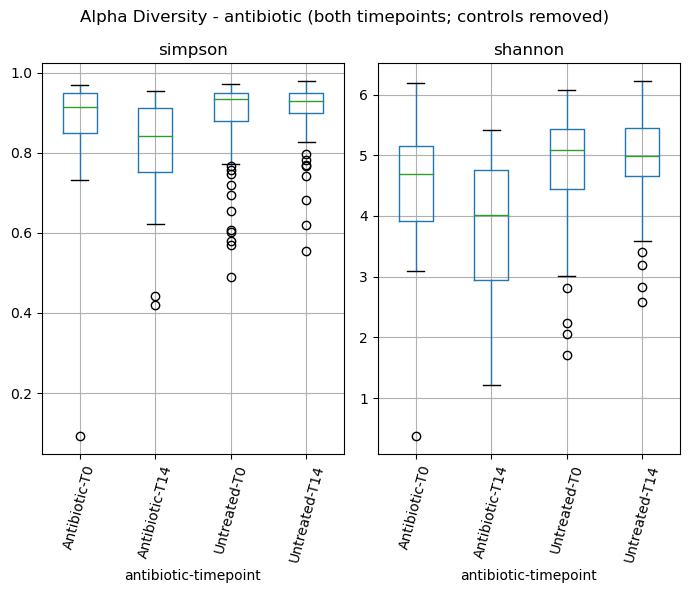

In [5]:
# alpha diversity - covid antibiotic (both timepoints, 4 groups, controls removed)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(antibiotic_df, groupby='antibiotic-timepoint', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(antibiotic_df, groupby='antibiotic-timepoint', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - antibiotic (both timepoints; controls removed)")
fig.tight_layout()

simpson_full.to_csv("./alpha_diversity/antibiotics_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/antibiotics_shannon.tsv", sep='\t')

print_n(antibiotic_df, 'antibiotic-timepoint')

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -71.06586576639651 and the largest is 1855.9655620892704.
  warn(


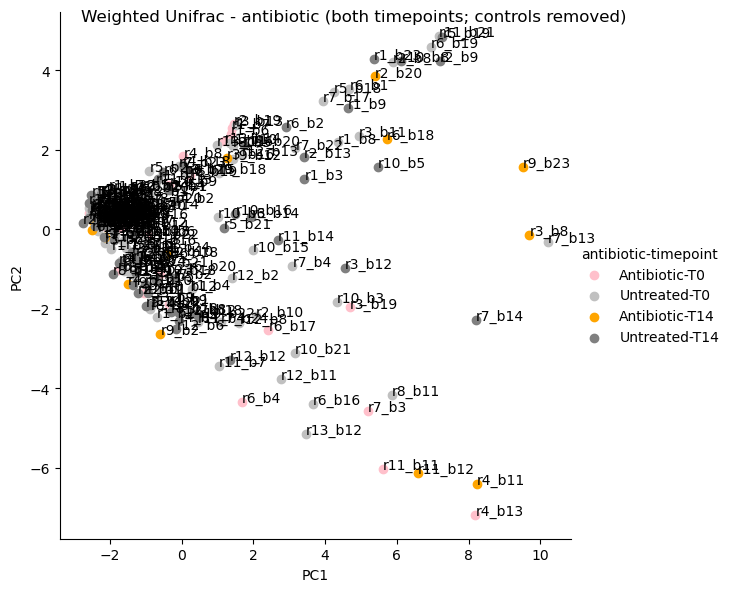

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -71.06586576639651 and the largest is 1855.9655620892704.
  warn(


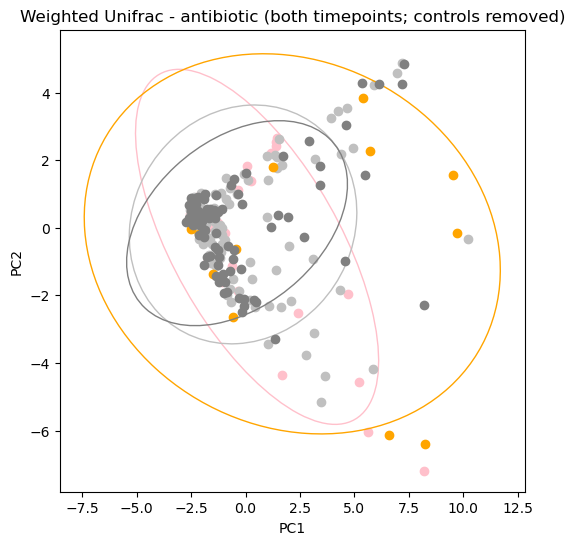

all: p:0.0016 r:0.08174910206544422
('Untreated-T0', 'Untreated-T14'): p:0.9147 r:-0.01186796092392732
('Untreated-T0', 'Antibiotic-T0'): p:0.0138 r:0.16436178052243075
('Untreated-T0', 'Antibiotic-T14'): p:0.032 r:0.18242091943337135
('Untreated-T14', 'Antibiotic-T0'): p:0.0019 r:0.22736592173748896
('Untreated-T14', 'Antibiotic-T14'): p:0.0182 r:0.21882298367144978
('Antibiotic-T0', 'Antibiotic-T14'): p:0.1751 r:0.05113297555158017


In [6]:
## beta diversity - covid antibiotic (both timepoints, 4 groups, controls removed)
antibiotic_beta_dm = unifrac_beta_plots(antibiotic_df, 'antibiotic-timepoint', antibiotic_colormap, "PC1", "PC2", 
                                        "Weighted Unifrac - antibiotic (both timepoints; controls removed)")
antibiotic_pvalues = compute_pvalues(antibiotic_beta_dm, antibiotic_df, 'antibiotic-timepoint')



/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -36.016802533015806 and the largest is 966.3948058047332.
  warn(


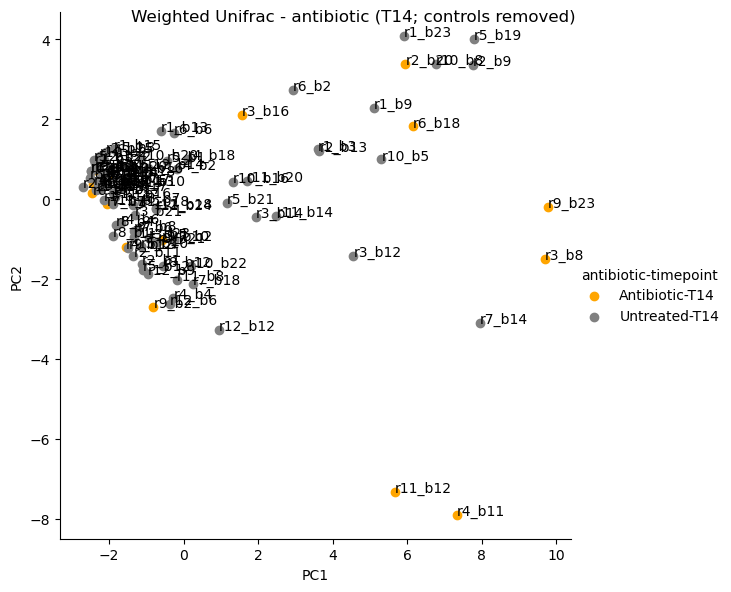

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -36.016802533015806 and the largest is 966.3948058047332.
  warn(


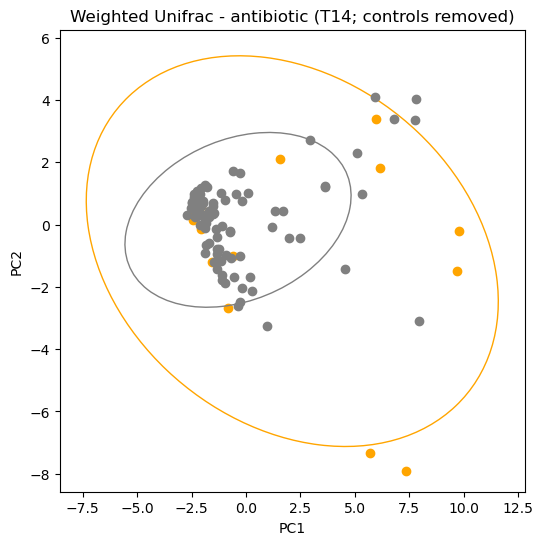

all: p:0.0174 r:0.21882298367144978
('Untreated-T14', 'Antibiotic-T14'): p:0.0182 r:0.21882298367144978


In [7]:
## beta diversity - covid antibiotic (T14, 2 groups controls removed)

antibiotic_14_df = antibiotic_df[antibiotic_df['antibiotic-timepoint'].isin(['Antibiotic-T14', 'Untreated-T14'])]
antibiotic_beta_dm = unifrac_beta_plots(antibiotic_14_df, 'antibiotic-timepoint', antibiotic_14_colormap, "PC1", "PC2", 
                                        "Weighted Unifrac - antibiotic (T14; controls removed)")
antibiotic_14_pvalues = compute_pvalues(antibiotic_beta_dm, antibiotic_14_df, 'antibiotic-timepoint')



In [8]:
# throw out patients with antibiotic treatment
before_n = len(abundance_df)
abundance_df['antibiotic'] = metadata_df['Antibiotic']
abundance_df['DNI'] = metadata_df['DNI']
before_patient_n = len(set(abundance_df['DNI']))

abundance_df = abundance_df[abundance_df['antibiotic'] != 'Antibiotic']
after_n = len(abundance_df)
after_patient_n = len(set(abundance_df['DNI']))
abundance_df = abundance_df.drop(columns=['DNI', 'antibiotic'])

## report how many samples/patients are removed for having antibiotics
print(f"\nTotal number of samples removed due to antibiotics: "
      f"{before_n-after_n}")
print(f"Total number of patients removed due to antibiotics: "
      f"{before_patient_n-after_patient_n}")


Total number of samples removed due to antibiotics: 41
Total number of patients removed due to antibiotics: 26


## Sex, COVID vs Control

In [9]:
## sex - remove T14
sex_groups = ['F-Control', 'M-Control', 'F-T0', 'M-T0']
sex_colors = ['pink', 'grey', 'maroon', 'steelblue']
sex_colormap = dict(zip(sex_groups, sex_colors))
sex_df = abundance_df.copy().fillna(0)
sex_df['sex'] = metadata_df['Sex']
sex_df['time'] = metadata_df['Time (T0/14)']
sex_df = sex_df[sex_df['sex'].isin(['M', 'F'])]
sex_df = sex_df[sex_df['time'].isin(['T0', 'Control'])]

sex_df['sex-time'] = sex_df['sex'] + "-" + sex_df['time']
sex_df = sex_df.drop(columns=['sex', 'time'])

F-T0: 56
M-Control: 20
M-T0: 48
F-Control: 32


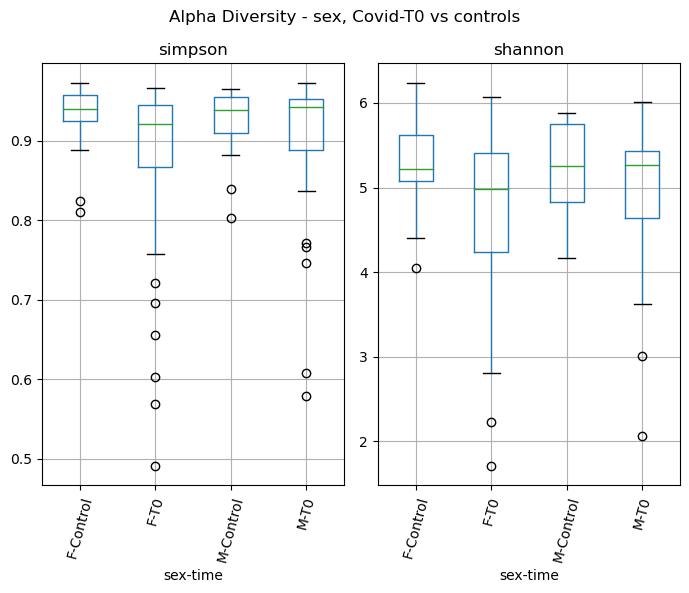

In [10]:
# alpha diversity - covid sex
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(sex_df, groupby='sex-time', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(sex_df, groupby='sex-time', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - sex, Covid-T0 vs controls")
fig.tight_layout()

print_n(sex_df, 'sex-time')

simpson_full.to_csv("./alpha_diversity/sex_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/sex_shannon.tsv", sep='\t')

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -37.719795165850435 and the largest is 950.7038878311156.
  warn(


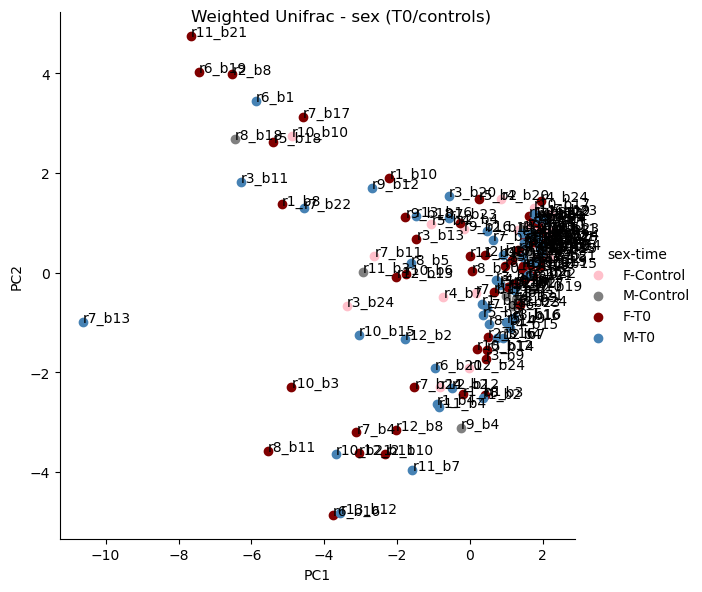

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -37.719795165850435 and the largest is 950.7038878311156.
  warn(


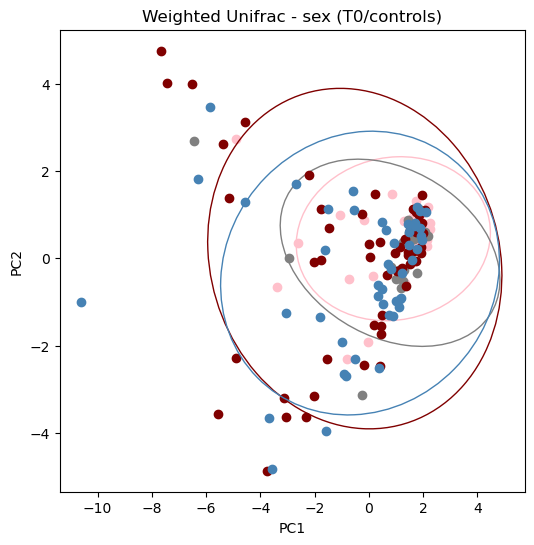

all: p:0.9977 r:-0.05629670220457354
('F-T0', 'F-Control'): p:0.9918 r:-0.07451476108616333
('F-T0', 'M-T0'): p:0.6661 r:-0.0074269505872065055
('F-T0', 'M-Control'): p:0.9959 r:-0.15120458298926517
('F-Control', 'M-T0'): p:0.6924 r:-0.01999347354782432
('F-Control', 'M-Control'): p:0.4352 r:0.0009520772594751975
('M-T0', 'M-Control'): p:0.9793 r:-0.11693301087506322


In [11]:
## beta diversity - covid infection

sex_beta_dm = unifrac_beta_plots(sex_df, "sex-time", sex_colormap, "PC1", "PC2", 
                                 "Weighted Unifrac - sex (T0/controls)")
sex_pvalues = compute_pvalues(sex_beta_dm, sex_df, "sex-time")

## Pneumonia

In [13]:
## pneumonia - remove T14
pneumonia_groups = ['no pneumonia', 'pneumonia', 'Control']
pneumonia_groupnames = ['no pneumonia-T0', 'pneumonia-T0', 'Control-Control', 'no pneumonia-T14', 'pneumonia-T14']
pneumonia_colors = ['olive', 'orange', 'steelblue', 'green', 'gold']
pneumonia_colormap = dict(zip(pneumonia_groupnames, pneumonia_colors))
pneumonia_0_colormap = dict(zip(pneumonia_groupnames[:3], pneumonia_colors[:3]))
pneumonia_14_colormap = dict(zip(pneumonia_groupnames[2:], pneumonia_colors[2:]))

pneumonia_df = abundance_df.copy().fillna(0)
pneumonia_df['pneumonia'] = metadata_df['pneumonia']
pneumonia_df['time'] = metadata_df['Time (T0/14)']
pneumonia_df['pneumonia-time'] = pneumonia_df['pneumonia'] + "-" + pneumonia_df['time']
pneumonia_df = pneumonia_df[pneumonia_df['pneumonia'].isin(pneumonia_groups)]
pneumonia_df_0 = pneumonia_df[pneumonia_df['time'].isin(['T0', 'Control'])]
pneumonia_df_14 = pneumonia_df[pneumonia_df['time'].isin(['T14', 'Control'])]

pneumonia_df = pneumonia_df.drop(columns=['pneumonia', 'time'])
pneumonia_df_0 = pneumonia_df_0.drop(columns=['pneumonia', 'time'])
pneumonia_df_14 = pneumonia_df_14.drop(columns=['pneumonia', 'time'])


no pneumonia-T0: 45
pneumonia-T14: 44
no pneumonia-T14: 42
pneumonia-T0: 59
Control-Control: 52


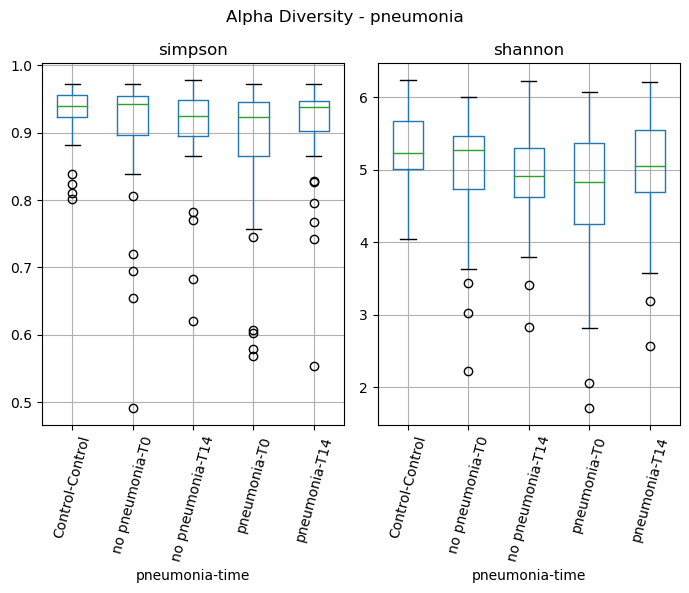

In [14]:
# alpha diversity - covid pneumonia
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(pneumonia_df, groupby='pneumonia-time', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(pneumonia_df, groupby='pneumonia-time', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - pneumonia")
fig.tight_layout()

print_n(pneumonia_df, 'pneumonia-time')

simpson_full.to_csv("./alpha_diversity/pneumonia_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/pneumonia_shannon.tsv", sep='\t')

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -55.56203214581679 and the largest is 1537.0982204471134.
  warn(


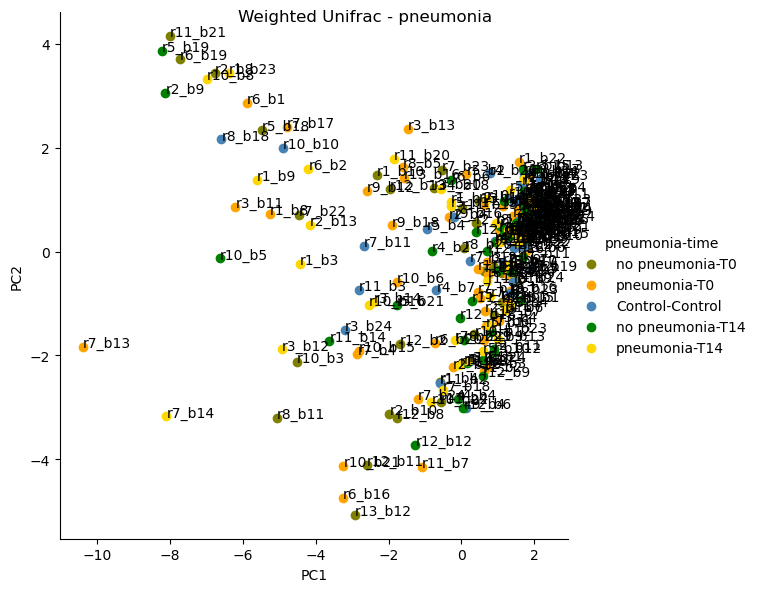

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -55.56203214581679 and the largest is 1537.0982204471134.
  warn(


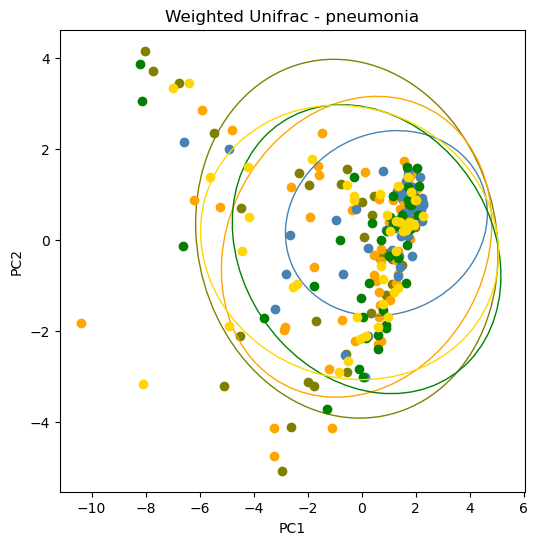

all: p:0.0052 r:0.02691176860253325
('no pneumonia-T0', 'Control-Control'): p:0.0001 r:0.11279670962313453
('no pneumonia-T0', 'no pneumonia-T14'): p:0.3191 r:0.0026549355560700387
('no pneumonia-T0', 'pneumonia-T0'): p:0.273 r:0.008746429271156576
('no pneumonia-T0', 'pneumonia-T14'): p:0.8803 r:-0.009839615159863065
('Control-Control', 'no pneumonia-T14'): p:0.001 r:0.08228317178934452
('Control-Control', 'pneumonia-T0'): p:0.0082 r:0.038703448429817496
('Control-Control', 'pneumonia-T14'): p:0.0001 r:0.10227157305722445
('no pneumonia-T14', 'pneumonia-T0'): p:0.9275 r:-0.030303843339270404
('no pneumonia-T14', 'pneumonia-T14'): p:0.932 r:-0.012544110565693291
('pneumonia-T0', 'pneumonia-T14'): p:0.5598 r:-0.0071227962535222395


In [15]:
## beta diversity - covid infection

pneumonia_beta_dm = unifrac_beta_plots(pneumonia_df, 'pneumonia-time', pneumonia_colormap, "PC1", "PC2", 
                                 "Weighted Unifrac - pneumonia")
pneumonia_pvalues = compute_pvalues(pneumonia_beta_dm, pneumonia_df, 'pneumonia-time')

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -37.719795165850435 and the largest is 950.7038878311156.
  warn(


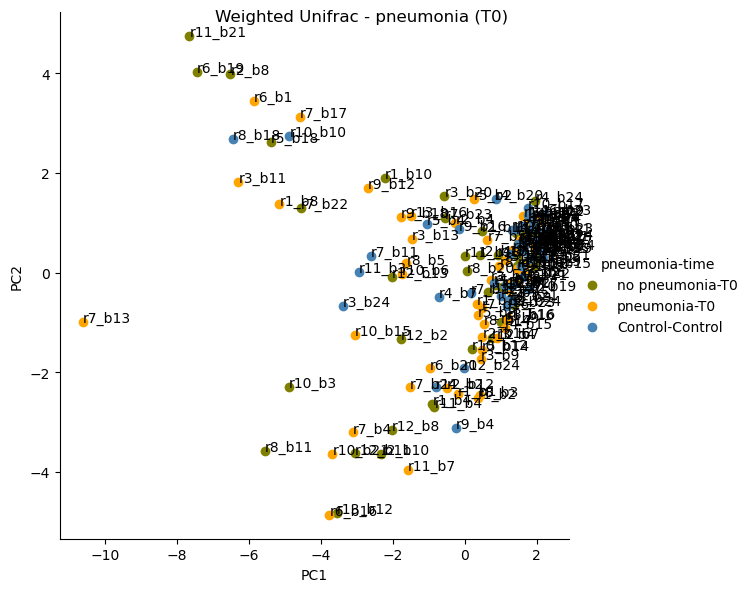

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -37.719795165850435 and the largest is 950.7038878311156.
  warn(


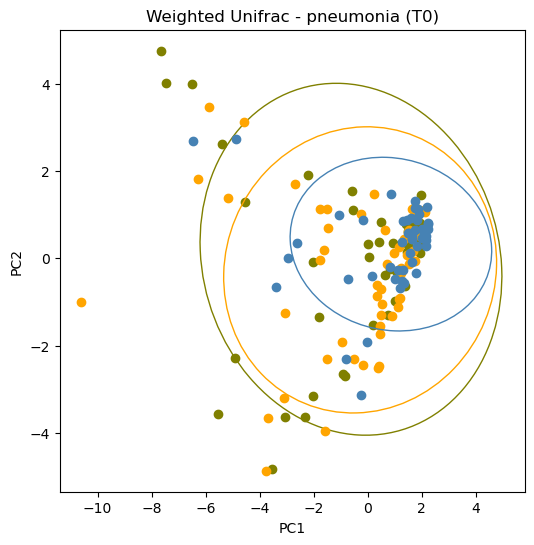

all: p:0.0014 r:0.046849615276715946
('no pneumonia-T0', 'Control-Control'): p:0.0001 r:0.11279670962313453
('no pneumonia-T0', 'pneumonia-T0'): p:0.2832 r:0.008746429271156576
('Control-Control', 'pneumonia-T0'): p:0.0106 r:0.038703448429817496


In [16]:
## beta diversity - covid infection

pneumonia_0_beta_dm = unifrac_beta_plots(pneumonia_df_0, 'pneumonia-time', pneumonia_0_colormap, "PC1", "PC2", 
                                 "Weighted Unifrac - pneumonia (T0)")
pneumonia_0_pvalues = compute_pvalues(pneumonia_0_beta_dm, pneumonia_df_0, 'pneumonia-time')

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -24.642082949343646 and the largest is 813.9749954699705.
  warn(


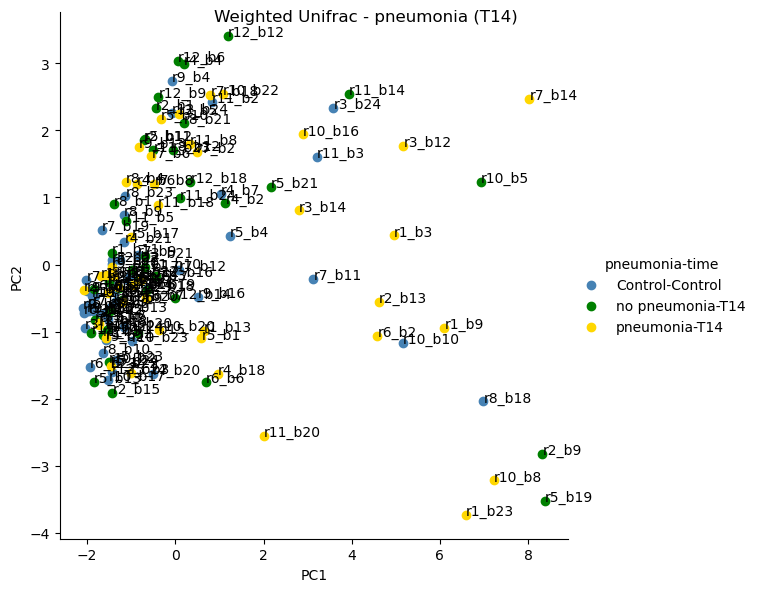

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -24.642082949343646 and the largest is 813.9749954699705.
  warn(


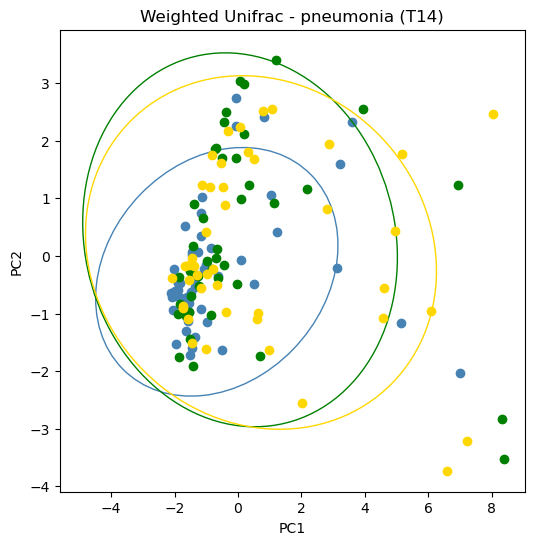

all: p:0.0002 r:0.06116862351367845
('Control-Control', 'no pneumonia-T14'): p:0.0016 r:0.08228317178934452
('Control-Control', 'pneumonia-T14'): p:0.0001 r:0.10227157305722445
('no pneumonia-T14', 'pneumonia-T14'): p:0.94 r:-0.012544110565693291


In [17]:
## beta diversity - covid infection

pneumonia_14_beta_dm = unifrac_beta_plots(pneumonia_df_14, 'pneumonia-time', pneumonia_14_colormap, "PC1", "PC2", 
                                 "Weighted Unifrac - pneumonia (T14)")
pneumonia_14_pvalues = compute_pvalues(pneumonia_14_beta_dm, pneumonia_df_14, 'pneumonia-time')

## Covid Infection at both timepoints vs Control

In [18]:
## covid infection
timepoint_groups = ['T0', 'T14', 'Control']
timepoint_colors = ['pink', 'maroon', 'steelblue']
timepoint_colormap = dict(zip(timepoint_groups, timepoint_colors))
timepoint_only_colormap = dict(zip(timepoint_groups[:2], timepoint_colors[:2]))

timepoint_df = abundance_df.copy().fillna(0)
timepoint_df['timepoint'] = metadata_df['Time (T0/14)']
timepoint_df = timepoint_df[timepoint_df['timepoint'].isin(timepoint_groups)]


T0: 104
T14: 86
Control: 52


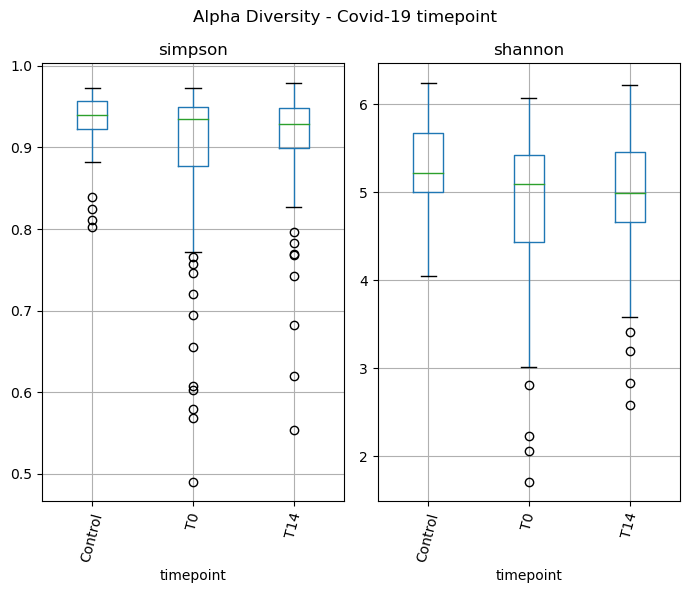

In [19]:
# alpha diversity - covid timepoint
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(timepoint_df, groupby='timepoint', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(timepoint_df, groupby='timepoint', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - Covid-19 timepoint")
fig.tight_layout()

print_n(timepoint_df, 'timepoint')

simpson_full.to_csv("./alpha_diversity/longitudinal_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/longitudinal_shannon.tsv", sep='\t')



/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -55.56203214581679 and the largest is 1537.0982204471134.
  warn(


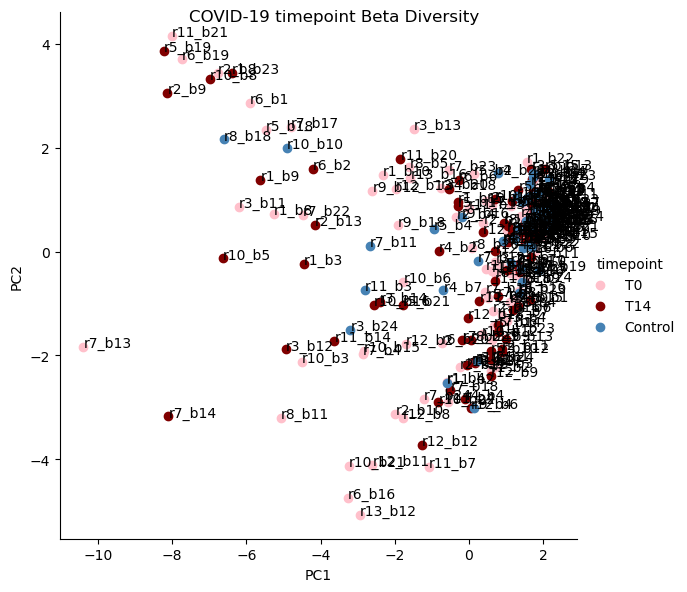

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -55.56203214581679 and the largest is 1537.0982204471134.
  warn(


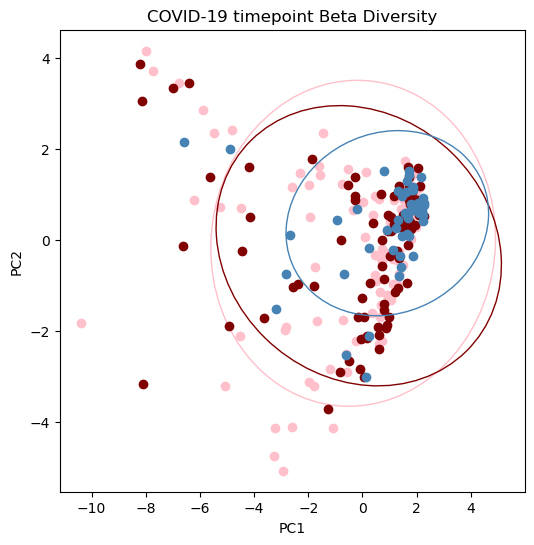

all: p:0.9996 r:-0.04183466807351292
('T0', 'Control'): p:0.9998 r:-0.09220886081834266
('T0', 'T14'): p:0.9124 r:-0.01186796092392732
('Control', 'T14'): p:0.9745 r:-0.04892145609487799


In [20]:
## beta diversity - covid infection

timepoint_beta_dm = unifrac_beta_plots(timepoint_df, "timepoint", timepoint_colormap, "PC1", "PC2", "COVID-19 timepoint Beta Diversity")
timepoint_pvalues = compute_pvalues(timepoint_beta_dm, timepoint_df, "timepoint")


/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -51.50936171644155 and the largest is 1308.461080175326.
  warn(


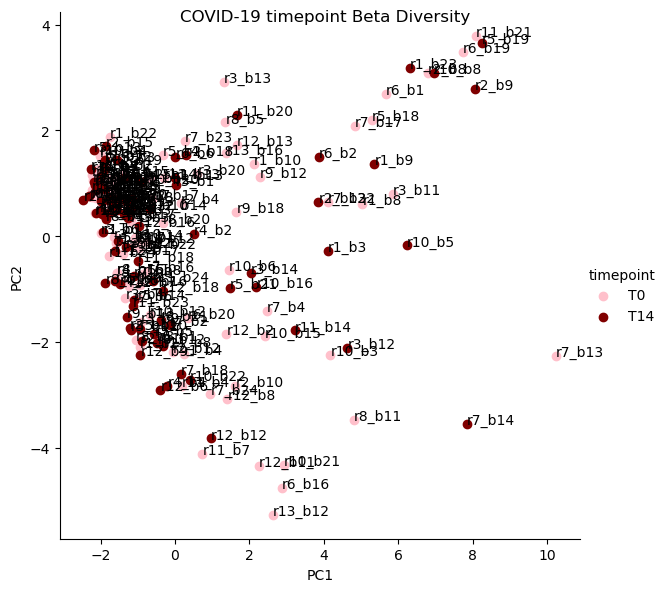

/Users/kcurry/opt/miniconda3/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -51.50936171644155 and the largest is 1308.461080175326.
  warn(


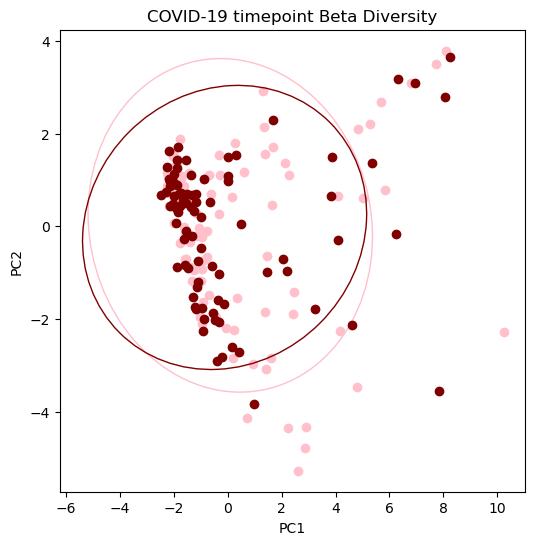

all: p:0.9135 r:-0.01186796092392732
('T0', 'T14'): p:0.913 r:-0.01186796092392732


In [21]:
## beta diversity - covid infection - remove controls


timepoint_only_df = timepoint_df[timepoint_df['timepoint'].isin(['T0', 'T14'])]
timepoint_beta_dm = unifrac_beta_plots(timepoint_only_df, "timepoint", timepoint_only_colormap, "PC1", "PC2", "COVID-19 timepoint Beta Diversity")
timepoint_pvalues = compute_pvalues(timepoint_beta_dm, timepoint_only_df, "timepoint")



## COVID & AGE GROUPS

In [ ]:
## covid infection
age_cat_groups = ['young-COVID', 'mid-COVID', 'old-COVID', 'young-Control', 'mid-Control', 'old-Control']
age_cat_colors = ['red', 'blue', 'grey', 'pink', 'steelblue', 'silver']
age_cat_colormap = dict(zip(age_cat_groups, age_cat_colors))
age_cat_colormap = dict(zip(age_cat_groups, age_cat_colors))
age_cat_covid_colormap = dict(zip(age_cat_groups[:3], age_cat_colors[:3]))


age_cat_df = abundance_df.copy().fillna(0)
age_cat_df['age_cat'] = metadata_df['age category_prev']
age_cat_df['COVID'] = metadata_df['COVID-19']
age_cat_df['age_cat-covid'] = age_cat_df['age_cat'] + "-" + age_cat_df['COVID']
age_cat_df = age_cat_df.drop(columns = ['age_cat', 'COVID'])

age_cat_df = age_cat_df[age_cat_df['age_cat-covid'].isin(age_cat_groups)]


In [ ]:
# alpha diversity - covid age_cat
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(age_cat_df, groupby='age_cat-covid', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(age_cat_df, groupby='age_cat-covid', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - Covid-19 Age Category (3 groups)")
fig.tight_layout()

print_n(age_cat_df, 'age_cat-covid')

simpson_full.to_csv("./alpha_diversity/age_cat-covid_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/age_cat-covid_shannon.tsv", sep='\t')


In [ ]:
## beta diversity - covid infection

age_cat_beta_dm = unifrac_beta_plots(age_cat_df, "age_cat-covid", age_cat_colormap, "PC1", "PC2", "COVID-19 age_cat Beta Diversity")
age_cat_pvalues = compute_pvalues(age_cat_beta_dm, age_cat_df, "age_cat-covid")


In [ ]:
## beta diversity - covid infection, remove controls

age_cat_df = age_cat_df[age_cat_df['age_cat-covid'].isin(['young-COVID', 'mid-COVID', 'old-COVID'])]
age_cat_beta_dm = unifrac_beta_plots(age_cat_df, "age_cat-covid", age_cat_covid_colormap, "PC1", "PC2", "COVID-19 age_cat Beta Diversity")
age_cat_pvalues = compute_pvalues(age_cat_beta_dm, age_cat_df, "age_cat-covid")


## COVID & BMI

In [ ]:
## covid infection
BMI_groups = ['Lean-COVID', 'Obese-COVID', 'Lean-Control', 'Obese-Control']
BMI_colors = ['pink', 'red', 'grey', 'steelblue']
BMI_colormap = dict(zip(BMI_groups, BMI_colors))
BMI_colormap = dict(zip(BMI_groups, BMI_colors))
BMI_covid_colormap = dict(zip(BMI_groups[:2], BMI_colors[:2]))


BMI_df = abundance_df.copy().fillna(0)
BMI_df['BMI'] = metadata_df['BMI']
BMI_df['COVID'] = metadata_df['COVID-19']
BMI_df['timepoint'] = metadata_df['Time (T0/14)']
BMI_df = BMI_df[BMI_df['BMI'].isin(['Lean', 'Obese'])]
BMI_T0_df = BMI_df[BMI_df['timepoint'].isin(['T0'])].drop(columns=['timepoint'])
BMI_df = BMI_df[BMI_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])


BMI_df['BMI-covid'] = BMI_df['BMI'] + "-" + BMI_df['COVID']
BMI_df = BMI_df.drop(columns = ['BMI', 'COVID'])
BMI_df = BMI_df[BMI_df['BMI-covid'].isin(BMI_groups)]



In [ ]:
# alpha diversity - covid BMI
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(BMI_df, groupby='BMI-covid', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(BMI_df, groupby='BMI-covid', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - Covid-19 BMI Category")
fig.tight_layout()

print_n(BMI_df, 'BMI-covid')

simpson_full.to_csv("./alpha_diversity/BMI-covid_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/BMI-covid_shannon.tsv", sep='\t')


In [ ]:
## beta diversity - BMI covid infection

BMI_beta_dm = unifrac_beta_plots(BMI_df, "BMI-covid", BMI_colormap, "PC1", "PC2", "COVID-19 BMI Beta Diversity")
BMI_pvalues = compute_pvalues(BMI_beta_dm, BMI_df, "BMI-covid")


In [ ]:
## beta diversity - BMI covid infection, remove controls

BMI_covid_df = BMI_df[BMI_df['BMI-covid'].isin(['Lean-COVID', 'Obese-COVID'])]
BMI_beta_dm = unifrac_beta_plots(BMI_covid_df, "BMI-covid", BMI_covid_colormap, "PC1", "PC2", 
                                 "COVID-19 BMI Beta Diversity")
BMI_pvalues = compute_pvalues(BMI_beta_dm, BMI_covid_df, "BMI-covid")


In [ ]:
BMI_df = abundance_df.copy().fillna(0)
BMI_df['BMI'] = metadata_df['BMI']
BMI_df['COVID'] = metadata_df['COVID-19']
BMI_df['timepoint'] = metadata_df['Time (T0/14)']
BMI_df = BMI_df[BMI_df['BMI'].isin(['Lean', 'Obese'])]
BMI_df = BMI_df[BMI_df['timepoint'].isin(['T14', 'Control'])].drop(columns=['timepoint'])


BMI_df['BMI-covid'] = BMI_df['BMI'] + "-" + BMI_df['COVID']
BMI_df = BMI_df.drop(columns = ['BMI', 'COVID'])
BMI_df = BMI_df[BMI_df['BMI-covid'].isin(BMI_groups)]

In [ ]:
# alpha diversity - covid BMI
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(BMI_df, groupby='BMI-covid', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(BMI_df, groupby='BMI-covid', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - Covid-19 BMI Category- T14")
fig.tight_layout()

print_n(BMI_df, 'BMI-covid')

simpson_full.to_csv("./alpha_diversity/BMI-covid_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/BMI-covid_shannon.tsv", sep='\t')

In [ ]:
## beta diversity - BMI covid infection

BMI_beta_dm = unifrac_beta_plots(BMI_df, "BMI-covid", BMI_colormap, "PC1", "PC2", "COVID-19 BMI Beta Diversity - T14")
BMI_pvalues = compute_pvalues(BMI_beta_dm, BMI_df, "BMI-covid")

In [ ]:
## beta diversity - BMI covid infection, remove controls

BMI_covid_df = BMI_df[BMI_df['BMI-covid'].isin(['Lean-COVID', 'Obese-COVID'])]
BMI_beta_dm = unifrac_beta_plots(BMI_covid_df, "BMI-covid", BMI_covid_colormap, "PC1", "PC2", 
                                 "COVID-19 BMI Beta Diversity - T14")
BMI_pvalues = compute_pvalues(BMI_beta_dm, BMI_covid_df, "BMI-covid")

## PNEUMONIA & BMI

In [ ]:
## covid infection
BMI_groups = ['Lean-pneumonia', 'Obese-pneumonia', 'Lean-no pneumonia', 'Obese-no pneumonia', 
              'Lean-Control', 'Obese-Control']
BMI_colors = ['orange', 'gold', 'olive', 'green', 'grey', 'steelblue']
BMI_colormap = dict(zip(BMI_groups, BMI_colors))
BMI_colormap = dict(zip(BMI_groups, BMI_colors))
BMI_covid_colormap = dict(zip(BMI_groups[:2], BMI_colors[:2]))


BMI_df = abundance_df.copy().fillna(0)
BMI_df['BMI'] = metadata_df['BMI']
BMI_df['timepoint'] = metadata_df['Time (T0/14)']
BMI_df['pneumonia'] = metadata_df['pneumonia']

BMI_df = BMI_df[BMI_df['BMI'].isin(['Lean', 'Obese'])]
BMI_df['BMI-pneumonia'] = BMI_df['BMI'] + "-" + BMI_df['pneumonia']
BMI_df = BMI_df.drop(columns = ['BMI', 'pneumonia'])
BMI_df = BMI_df[BMI_df['BMI-pneumonia'].isin(BMI_groups)]


BMI_df_T0 = BMI_df[BMI_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])
BMI_df_T14 = BMI_df[BMI_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])



In [ ]:
# alpha diversity - covid BMI
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(BMI_df_T0, groupby='BMI-pneumonia', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(BMI_df_T0, groupby='BMI-pneumonia', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - Covid-19 BMI Category- T0")
fig.tight_layout()

print("Counts BMI-pneumonia at T0\n")
print_n(BMI_df_T0, 'BMI-pneumonia')

simpson_full.to_csv("./alpha_diversity/BMI-pneumonia_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/BMI-pneumonia_shannon.tsv", sep='\t')

In [ ]:
## beta diversity - BMI pneumonia

BMI_beta_dm_0 = unifrac_beta_plots(BMI_df_T0, "BMI-pneumonia", BMI_colormap, "PC1", "PC2", 
                                 "Pneumonia/ BMI Beta Diversity - T0")
BMI_pvalues = compute_pvalues(BMI_beta_dm_0, BMI_df_T0, "BMI-pneumonia")

In [ ]:
# alpha diversity - covid BMI
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(BMI_df_T14, groupby='BMI-pneumonia', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(BMI_df_T14, groupby='BMI-pneumonia', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - Covid-19 BMI Category- T14")
fig.tight_layout()

print("Counts BMI-pneumonia at T14\n")
print_n(BMI_df_T14, 'BMI-pneumonia')

simpson_full.to_csv("./alpha_diversity/BMI-pneumonia_simpson.tsv", sep='\t')
shannon_full.to_csv("./alpha_diversity/BMI-pneumonia_shannon.tsv", sep='\t')

In [ ]:
## beta diversity - BMI pneumonia

BMI_beta_dm_14 = unifrac_beta_plots(BMI_df_T14, "BMI-pneumonia", BMI_colormap, "PC1", "PC2", 
                                 "COVID-19 BMI Beta Diversity - T14")
BMI_pvalues = compute_pvalues(BMI_beta_dm_14, BMI_df_T14, "BMI-pneumonia")

# Covid Severity 


In [ ]:
## covid severity
severity_df = abundance_df.copy().fillna(0)
severity_df['severity'] = metadata_df['COVID19_severity']
severity_df['timepoint'] = metadata_df['Time (T0/14)']
severity_df_0 = severity_df[severity_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])
severity_df_14 = severity_df[severity_df['timepoint'].isin(['T14', 'Control'])].drop(columns=['timepoint'])
severity_groups = ['Severe', 'Moderate', 'Mild', 'Control']
severity_colors = ['red', 'gold', 'olive', 'steelblue'] 
severity_colormap = dict(zip(severity_groups, severity_colors))

## KL diversity for each group
display("T0:", group_KL_div(severity_df_0, 'severity'))
display("T14:", group_KL_div(severity_df_14, 'severity'))

In [ ]:
# alpha diversity - severity T0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(severity_df_0, groupby='severity', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(severity_df_0, groupby='severity', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - antibiotic treated vs not")
fig.tight_layout()

print("n for timepoint 0:")
print_n(severity_df_0, 'severity')

shannon_full.to_csv(f"./alpha_diversity/T0_severity_groups_shannon.tsv", sep='\t')
simpson_full.to_csv(f"./alpha_diversity/T0_severity_groups_simpson.tsv", sep='\t')




In [ ]:
## beta diversity - covid severity
print("n for timepoint 0:")
print_n(severity_df_0, "severity")
severity_0_beta_dm = unifrac_beta_plots(severity_df_0, "severity", severity_colormap, "PC1", "PC2", "COVID-19 Severity Beta Diversity - timepoint 0")
severity_0_pvalues = compute_pvalues(severity_0_beta_dm, severity_df_0, "severity")

print("n for timepoint 14:")
print_n(severity_df_14, "severity")
severity_14_beta_dm = unifrac_beta_plots(severity_df_14, "severity", severity_colormap, "PC1", "PC2", "COVID-19 Severity Beta Diversity - timepoint 14")
severity_14_pvalues = compute_pvalues(severity_14_beta_dm, severity_df_14, "severity")

In [ ]:
LEVEL = "species"  # choose from "genus", "species", "family"
TYPE = "fecal"  # choose from "fecal"

four_groups = ["Mild", "Moderate", "Severe", "Control"]  # must match the metadata file labels
four_group_colors = ["green", "yellow", "red", "blue"]
four_group_colors_dict = dict(zip(four_groups, four_group_colors))
four_group_colors_series = severity_df_0["severity"].map(four_group_colors_dict)

plot_clustermap(severity_df_0.drop(columns=['severity']).transpose(), colors_series=four_group_colors_series)

## Covid timepoint vs control separated by sex

In [ ]:
## covid infection
timepoint_groups = ['T0', 'T14', 'Control']
timepoint_colors = ['pink', 'maroon', 'steelblue']
timepoint_colormap = dict(zip(timepoint_groups, timepoint_colors))
timepoint_df = abundance_df.copy().fillna(0)
timepoint_df['timepoint'] = metadata_df['Time (T0/14)']
timepoint_df['sex'] = metadata_df['Sex']
timepoint_df = timepoint_df[timepoint_df['timepoint'].isin(timepoint_groups)]

timepoint_df_M = timepoint_df[timepoint_df['sex']=='M'].drop(columns=['sex'])
timepoint_df_F = timepoint_df[timepoint_df['sex']=='F'].drop(columns=['sex'])


In [ ]:
## beta diversity - covid infection, FEMALES

print_n(timepoint_df_F, 'timepoint')
timepoint_beta_F_dm = unifrac_beta_plots(timepoint_df_F, "timepoint", timepoint_colormap, "PC1", "PC2", "COVID-19 timepoint Beta Diversity - FEMALES")
timepoint_pvalues = compute_pvalues(timepoint_beta_F_dm, timepoint_df_F, "timepoint")



In [ ]:
## beta diversity - covid infection, MALES

print_n(timepoint_df_M, 'timepoint')
timepoint_beta_M_dm = unifrac_beta_plots(timepoint_df_M, "timepoint", timepoint_colormap, "PC1", "PC2", "COVID-19 timepoint Beta Diversity - MALES")
timepoint_pvalues = compute_pvalues(timepoint_beta_M_dm, timepoint_df_M, "timepoint")


## Covid severity groups separated by sex

In [ ]:
severity_df = abundance_df.copy().fillna(0)
severity_df['severity'] = metadata_df['COVID19_severity']
severity_df['timepoint'] = metadata_df['Time (T0/14)']
severity_df['sex'] = metadata_df['Sex']
severity_F_df = severity_df[severity_df['sex'].isin(['F'])].drop(columns=['sex'])
severity_M_df = severity_df[severity_df['sex'].isin(['M'])].drop(columns=['sex'])

severity_df_M_0 = severity_M_df[severity_M_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])
severity_df_M_14 = severity_M_df[severity_M_df['timepoint'].isin(['T14', 'Control'])].drop(columns=['timepoint'])
severity_df_F_0 = severity_F_df[severity_F_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])
severity_df_F_14 = severity_F_df[severity_F_df['timepoint'].isin(['T14', 'Control'])].drop(columns=['timepoint'])


severity_groups = ['Severe', 'Moderate', 'Mild', 'Control']
severity_colors = ['red', 'gold', 'olive', 'steelblue'] 
severity_colormap = dict(zip(severity_groups, severity_colors))

In [ ]:
## beta diversity - severity - MALE
print("n for Male timepoint 0:")
print_n(severity_df_M_0, "severity")
severity_0_beta_M_dm = unifrac_beta_plots(severity_df_M_0, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 0, Male")
severity_0_pvalues = compute_pvalues(severity_0_beta_M_dm, severity_df_M_0, "severity")

print("n for Male timepoint 14:")
print_n(severity_df_M_14, "severity")
severity_14_beta_M_dm = unifrac_beta_plots(severity_df_M_14, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 14, Male")
severity_14_pvalues = compute_pvalues(severity_14_beta_M_dm, severity_df_M_14, "severity")



In [ ]:
## beta diversity - severity - FEMALE
print("n for Female timepoint 0:")
print_n(severity_df_F_0, "severity")
severity_0_beta_F_dm = unifrac_beta_plots(severity_df_F_0, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 0, Female")
severity_0_pvalues = compute_pvalues(severity_0_beta_F_dm, severity_df_F_0, "severity")

print("n for Female timepoint 14:")
print_n(severity_df_F_14, "severity")
severity_14_beta_F_dm = unifrac_beta_plots(severity_df_F_14, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 14, Female")
severity_14_pvalues = compute_pvalues(severity_14_beta_F_dm, severity_df_F_14, "severity")


## Covid ages separated by pneumonia (severity)- UPDATED (pneumonia/2 age groups) 

In [ ]:
age_groups = ['young', 'old']
age_pneumonia_groups = ['young-pneumonia', 'old-pneumonia', 'young-no pneumonia', 'old-no pneumonia']
age_pneumonia_colors = ['orange', 'gold', 'olive', 'green']
age_pneumonia_colormap = dict(zip(age_pneumonia_groups, age_pneumonia_colors))
age_pneumonia_yes_colormap = dict(zip(age_pneumonia_groups[:2], age_pneumonia_colors[:2]))
age_pneumonia_no_colormap = dict(zip(age_pneumonia_groups[2:], age_pneumonia_colors[2:]))


age_df = abundance_df.copy().fillna(0)
age_df['age_cat'] = metadata_df['age_cat']
age_df['pneumonia'] = metadata_df['pneumonia']
age_df['timepoint'] = metadata_df['Time (T0/14)']
age_df = age_df[age_df['pneumonia'].isin(['pneumonia', 'no pneumonia'])]                                  
age_df = age_df[age_df['timepoint'].isin(['T0','T14'])]
age_df['age-pneumonia'] = age_df["age_cat"] + "-" + age_df["pneumonia"]
age_df = age_df.drop(columns=['age_cat'])

age_df_T0 = age_df[age_df['timepoint'].isin(['T0'])]
age_df_T14 = age_df[age_df['timepoint'].isin(['T14'])]
age_df_T0 = age_df_T0.drop(columns=['timepoint'])
age_df_T14 = age_df_T14.drop(columns=['timepoint'])
age_df = age_df.drop(columns=['pneumonia', 'timepoint'])

age_df_pneumonia_T0 = age_df_T0[age_df_T0['pneumonia'] == 'pneumonia'].drop(columns=['pneumonia'])
age_df_no_pneumonia_T0 = age_df_T0[age_df_T0['pneumonia'] == 'no pneumonia'].drop(columns=['pneumonia'])
age_df_pneumonia_T14 = age_df_T14[age_df_T14['pneumonia'] == 'pneumonia'].drop(columns=['pneumonia'])
age_df_no_pneumonia_T14 = age_df_T14[age_df_T14['pneumonia'] == 'no pneumonia'].drop(columns=['pneumonia'])

In [ ]:
# alpha diversity - age & pneumonia
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(age_df, groupby='age-pneumonia', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(age_df, groupby='age-pneumonia', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - pneumonia & age")
fig.tight_layout()

print("n for age-pneumonia:")
print_n(age_df, 'age-pneumonia')

shannon_full.to_csv(f"./alpha_diversity/age-pneumonia_shannon.tsv", sep='\t')
simpson_full.to_csv(f"./alpha_diversity/age-pneumonia_simpson.tsv", sep='\t')


In [ ]:
# alpha diversity - severity T0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(age_df, groupby='age-pneumonia', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(age_df, groupby='age-pneumonia', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - pneumonia & age")
fig.tight_layout()

print("n for age-pneumonia T0:")
print_n(age_df_T0, 'age-pneumonia')


In [ ]:
# alpha diversity - severity 14
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(age_df, groupby='age-pneumonia', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(age_df, groupby='age-pneumonia', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - pneumonia & age")
fig.tight_layout()

print("n for age-pneumonia T14:")
print_n(age_df_T14, 'age-pneumonia')

In [ ]:
## beta diversity - age - pneumonia-T0


age_df_pneumonia_T0_dm = unifrac_beta_plots(age_df_pneumonia_T0, 'age-pneumonia', age_pneumonia_yes_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, pneumonia")
age_df_pneumonia_T0_pvalues = compute_pvalues(age_df_pneumonia_T0_dm, age_df_pneumonia_T0, 'age-pneumonia')

In [ ]:
## beta diversity - age - no pneumonia-T0


age_df_no_pneumonia_T0_dm = unifrac_beta_plots(age_df_no_pneumonia_T0, 'age-pneumonia', age_pneumonia_no_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, no pneumonia")
age_df_no_pneumonia_T0_pvalues = compute_pvalues(age_df_no_pneumonia_T0_dm, age_df_no_pneumonia_T0, 'age-pneumonia')



In [ ]:
## beta diversity - age - pneumonia-T14


age_df_pneumonia_T14_dm = unifrac_beta_plots(age_df_pneumonia_T14, 'age-pneumonia', age_pneumonia_yes_colormap, 
                                    "PC1", "PC2", "Age - timepoint 14, pneumonia")
age_df_pneumonia_T14_pvalues = compute_pvalues(age_df_pneumonia_T14_dm, age_df_pneumonia_T14, 'age-pneumonia')



In [ ]:
## beta diversity - age - no pneumonia-T14


age_df_no_pneumonia_T14_dm = unifrac_beta_plots(age_df_no_pneumonia_T14, 'age-pneumonia', age_pneumonia_no_colormap, 
                                    "PC1", "PC2", "Age - timepoint 14, no pneumonia")
age_df_no_pneumonia_T14_pvalues = compute_pvalues(age_df_no_pneumonia_T14_dm, age_df_no_pneumonia_T14, 'age-pneumonia')



## pneumonia & severity

In [ ]:
pneumonia_sev_groups = ['Moderate', 'Severe']
pneumonia_sev_colors = ['yellow', 'red']
pneumonia_sev_colormap = dict(zip(pneumonia_sev_groups, pneumonia_sev_colors))


pneumonia_sev_df = abundance_df.copy().fillna(0)
pneumonia_sev_df['pneumonia'] = metadata_df['pneumonia']
pneumonia_sev_df['severity'] = metadata_df['COVID19_severity']
pneumonia_sev_df = pneumonia_sev_df[pneumonia_sev_df['pneumonia']=='pneumonia'].drop(columns=['pneumonia'])



In [ ]:
# alpha diversity - severity 14
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(pneumonia_sev_df, groupby='severity', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(pneumonia_sev_df, groupby='severity', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - severity within pneumonia")
fig.tight_layout()

print("n for severity in pneumonia")
print_n(pneumonia_sev_df, 'severity')

In [ ]:
## beta diversity - age - no pneumonia-T14


pneumonia_sev_dm = unifrac_beta_plots(pneumonia_sev_df, 'severity', pneumonia_sev_colormap, 
                                    "PC1", "PC2", "pneumonia - severity")
pneumonia_sev_pvalues = compute_pvalues(pneumonia_sev_dm, pneumonia_sev_df, 'severity')


## Covid ages separated by severity 

In [ ]:
age_groups = ['young', 'old']
age_colors = ['steelblue', 'silver']
age_colormap = dict(zip(age_groups, age_colors))
age_combine_colormap = dict(zip(age_combine_groups, age_colors[1:]))


age_df = abundance_df.copy().fillna(0)
age_df['age_cat'] = metadata_df['age_cat']
age_df['severity'] = metadata_df['COVID19_severity']
age_df['timepoint'] = metadata_df['Time (T0/14)']
age_df_T0 = age_df[age_df['timepoint'].isin(['T0','Control'])]
age_df_T14 = age_df[age_df['timepoint'].isin(['T14'])]
age_df_T0 = age_df_T0.drop(columns=['timepoint'])
age_df_T14 = age_df_T14.drop(columns=['timepoint'])


age_df_T0_mild = age_df_T0[age_df_T0['severity'] == 'Mild'].drop(columns=['severity'])
age_df_T0_moderate = age_df_T0[age_df_T0['severity'] == 'Moderate'].drop(columns=['severity'])
age_df_T0_severe = age_df_T0[age_df_T0['severity'] == 'Severe'].drop(columns=['severity'])
age_df_T0_control = age_df_T0[age_df_T0['severity'] == 'Control'].drop(columns=['severity'])
age_df_T14_mild = age_df_T14[age_df_T14['severity'] == 'Mild'].drop(columns=['severity'])
age_df_T14_moderate = age_df_T14[age_df_T14['severity'] == 'Moderate'].drop(columns=['severity'])
age_df_T14_severe = age_df_T14[age_df_T14['severity'] == 'Severe'].drop(columns=['severity'])


In [ ]:
## beta diversity - age - control severity


print("n for control severity:")
print_n(age_df_T0_control , "age_cat")
age_df_control_T0_dm = unifrac_beta_plots(age_df_T0_control, "age_cat", age_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, control severity")
age_df_control_T0_pvalues = compute_pvalues(age_df_control_T0_dm, age_df_T0_control, "age_cat")

In [ ]:
## beta diversity - age - mild severity


print("n for MILD severity:")
print_n(age_df_T0_mild , "age_cat")
age_df_mild_T0_dm = unifrac_beta_plots(age_df_T0_mild, "age_cat", age_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, Mild severity")
age_df_mild_T0_pvalues = compute_pvalues(age_df_mild_T0_dm, age_df_T0_mild, "age_cat")


In [ ]:
## beta diversity - age - Moderate severity


print("n for Moderate severity:")
print_n(age_df_T0_moderate , "age_cat")
age_df_T0_moderate_dm = unifrac_beta_plots(age_df_T0_moderate, "age_cat", age_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, Moderate severity")
age_df_T0_moderate_pvalues = compute_pvalues(age_df_T0_moderate_dm, age_df_T0_moderate, "age_cat")

In [ ]:
## beta diversity - age - severe severity


print("n for severe severity:")
print_n(age_df_T0_severe , "age_cat")
age_df_T0_severe_dm = unifrac_beta_plots(age_df_T0_severe, "age_cat", age_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, severe severity")
age_df_T0_severe_pvalues = compute_pvalues(age_df_T0_severe_dm, age_df_T0_severe, "age_cat")

In [ ]:
## beta diversity - age - mild severity


print("n for mild severity:")
print_n(age_df_T14_mild , "age_cat")
age_df_mild_T14_dm = unifrac_beta_plots(age_df_T14_mild, "age_cat", age_colormap, 
                                    "PC1", "PC2", "Age - timepoint 14, mild severity")
age_df_mild_T14_pvalues = compute_pvalues(age_df_mild_T14_dm, age_df_T14_mild, "age_cat")

In [ ]:
## beta diversity - age - moderate severity


print("n for moderate severity:")
print_n(age_df_T14_moderate , "age_cat")
age_df_moderate_T14_dm = unifrac_beta_plots(age_df_T14_moderate, "age_cat", age_colormap, 
                                    "PC1", "PC2", "Age - timepoint 14, moderate severity")
age_df_moderate_T14_pvalues = compute_pvalues(age_df_moderate_T14_dm, age_df_T14_moderate, "age_cat")

In [ ]:
## beta diversity - age - severe severity


print("n for severe severity:")
print_n(age_df_T14_severe , "age_cat")
age_df_severe_T14_dm = unifrac_beta_plots(age_df_T14_severe, "age_cat", age_colormap, 
                                    "PC1", "PC2", "Age - timepoint 14, severe severity")
age_df_severe_T14_pvalues = compute_pvalues(age_df_severe_T14_dm, age_df_T14_severe, "age_cat")

In [ ]:
# alpha diversity - covid severe - age groups
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(age_df_T0_severe, groupby='age_cat', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(age_df_T0_severe, groupby='age_cat', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - age (Covid severe-T0)")
fig.tight_layout()

print_n(age_df_T0_severe, 'age_cat')


In [ ]:
age_df_severe = age_df[age_df['severity'] == 'Severe'].drop(columns=['severity'])
## combine young/mid for severe
def combine_young_mid(val):
    if val == 'young' or val == 'mid':
        return "young/mid"
    return val

age_df_severe['age_cat'] = age_df_severe['age_cat'].apply(lambda x: combine_young_mid(x))

print("n for severe severity:")

print_n(age_df_severe , "age_cat")
age_df_severe_dm = unifrac_beta_plots(age_df_severe, "age_cat", age_combine_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, severe severity")
age_df_severe_pvalues = compute_pvalues(age_df_severe_dm, age_df_severe, "age_cat")


In [ ]:
## beta diversity - age - severe severity


print("n for severe severity:")
print_n(age_df_severe , "age_cat")
age_df_severe_dm = unifrac_beta_plots(age_df_severe, "age_cat", age_combine_colormap, 
                                    "PC1", "PC2", "Age - timepoint 0, severe severity")
age_df_severe_pvalues = compute_pvalues(age_df_severe_dm, age_df_severe, "age_cat")

## Covid severity groups separated by age

In [ ]:
severity_groups = ['Severe', 'Moderate', 'Mild', 'Control']
severity_colors = ['red', 'gold', 'olive', 'steelblue'] 
severity_colormap = dict(zip(severity_groups, severity_colors))
severity_df = abundance_df.copy().fillna(0)
severity_df['severity'] = metadata_df['COVID19_severity']
severity_df['timepoint'] = metadata_df['Time (T0/14)']
severity_df['age'] = metadata_df['Age']
severity_df = severity_df[severity_df['severity'].isin(severity_groups)]
severity_young_df = severity_df[severity_df['age'] <= 40].drop(columns=['age'])
severity_mid_df = severity_df[severity_df['age'].between(41, 59)].drop(columns=['age'])
severity_old_df = severity_df[severity_df['age']>=60].drop(columns=['age'])

## combine mod/severe for young age
def combine_moderate_severe(val):
    if val == 'Moderate' or val == 'Severe':
        return "Moderate/Severe"
    return val
severity_young_df['severity'] = severity_young_df['severity'].apply(lambda x: combine_moderate_severe(x))


severity_df_young_0 = severity_young_df[severity_young_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])
severity_df_young_14 = severity_young_df[severity_young_df['timepoint'].isin(['T14', 'Control'])].drop(columns=['timepoint'])
severity_df_mid_0 = severity_mid_df[severity_mid_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])
severity_df_mid_14 = severity_mid_df[severity_mid_df['timepoint'].isin(['T14', 'Control'])].drop(columns=['timepoint'])
severity_df_old_0 = severity_old_df[severity_old_df['timepoint'].isin(['T0', 'Control'])].drop(columns=['timepoint'])
severity_df_old_14 = severity_old_df[severity_old_df['timepoint'].isin(['T14', 'Control'])].drop(columns=['timepoint'])

severity_combine_mod_sev_groups = ['Moderate/Severe', 'Mild', 'Control']
severity_combine_mod_sev_colors = ['red', 'olive', 'steelblue'] 
severity_combine_mod_sev_colormap = dict(zip(severity_combine_mod_sev_groups, severity_combine_mod_sev_colors))



In [ ]:
## beta diversity - severity - YOUNG age


print("n for YOUNG age timepoint 0:")
print_n(severity_df_young_0, "severity")
severity_0_beta_young_dm = unifrac_beta_plots(severity_df_young_0, "severity", severity_combine_mod_sev_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 0, YOUNG age")
severity_0_pvalues = compute_pvalues(severity_0_beta_young_dm, severity_df_young_0, "severity")

print("n for YOUNG age timepoint 14:")
print_n(severity_df_young_14, "severity")
severity_14_beta_young_dm = unifrac_beta_plots(severity_df_young_14, "severity", severity_combine_mod_sev_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 14, YOUNG age")
severity_14_pvalues = compute_pvalues(severity_14_beta_young_dm, severity_df_young_14, "severity")


In [ ]:
## beta diversity - severity - MID age
print("n for MID age timepoint 0:")
print_n(severity_df_mid_0, "severity")
severity_0_beta_mid_dm = unifrac_beta_plots(severity_df_mid_0, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 0, MID age")
severity_0_pvalues = compute_pvalues(severity_0_beta_mid_dm, severity_df_mid_0, "severity")

print("n for MID age timepoint 14:")
print_n(severity_df_mid_14, "severity")
severity_14_beta_mid_dm = unifrac_beta_plots(severity_df_mid_14, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 14, MID age")
severity_14_pvalues = compute_pvalues(severity_14_beta_mid_dm, severity_df_mid_14, "severity")


In [ ]:
## beta diversity - severity - OLD age
print("n for old age timepoint 0:")
print_n(severity_df_old_0, "severity")
severity_0_beta_old_dm = unifrac_beta_plots(severity_df_old_0, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 0, OLD age")
severity_0_pvalues = compute_pvalues(severity_0_beta_old_dm, severity_df_old_0, "severity")

print("n for old age timepoint 14:")
print_n(severity_df_old_14, "severity")
severity_14_beta_old_dm = unifrac_beta_plots(severity_df_old_14, "severity", severity_colormap, "PC1", "PC2", "COVID-19 severity Beta Diversity - timepoint 14, OLD age")
severity_14_pvalues = compute_pvalues(severity_14_beta_old_dm, severity_df_old_14, "severity")


## Tannins vs Placebo Treatment at T0/T14

In [ ]:
## keep only patients with both timepoints 
patients = metadata_df['DNI'].unique()
patients_longitudinal = []
for p in patients:
    l = list(metadata_df[metadata_df['DNI'] == p]['Time (T0/14)'])
    if(set(l) == {'T0','T14'}):
        patients_longitudinal.append(p)
    

timepoint_groups = ['T0', 'T14']
treatment_groups = ['Placebo', 'Tannins']
treatment_colors = ['grey', 'maroon']
treatment_colormap = dict(zip(treatment_groups, treatment_colors))

treatment_df = abundance_df.copy().fillna(0)
treatment_df['treatment'] = metadata_df['Treatment']
treatment_df['timepoint'] = metadata_df['Time (T0/14)']
treatment_df['DNI'] = metadata_df['DNI']
treatment_df = treatment_df[treatment_df['DNI'].isin(patients_longitudinal)].drop(columns=['DNI'])
treatment_df_0 = treatment_df[treatment_df['timepoint'].isin(['T0'])].drop(columns=['timepoint'])
treatment_df_14 = treatment_df[treatment_df['timepoint'].isin(['T14'])].drop(columns=['timepoint'])



In [ ]:
# alpha diversity - treatment 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(treatment_df_0, groupby='treatment', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(treatment_df_0, groupby='treatment', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - treatment for COVID-19 patients at timepoint 0")
fig.tight_layout()
print_n(treatment_df_0, 'treatment')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(treatment_df_14, groupby='treatment', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(treatment_df_14, groupby='treatment', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - treatment for COVID-19 patients at timepoint 14")
fig.tight_layout()



In [ ]:
## beta diversity - treatment
print("n for timepoint 0:")
print_n(treatment_df_0, "treatment")
treatment_0_beta_dm = unifrac_beta_plots(treatment_df_0, "treatment", treatment_colormap, "PC1", "PC2", "COVID-19 treatment Beta Diversity - timepoint 0")
treatment_0_pvalues = compute_pvalues(treatment_0_beta_dm, treatment_df_0, "treatment")

print("n for timepoint 14:")
print_n(treatment_df_14, "treatment")
treatment_14_beta_dm = unifrac_beta_plots(treatment_df_14, "treatment", treatment_colormap, "PC1", "PC2", "COVID-19 treatment Beta Diversity - timepoint 14")
treatment_14_pvalues = compute_pvalues(treatment_14_beta_dm, treatment_df_14, "treatment")

# Change in Tannins vs Placebo Treatment at T0/T14 - INCLUDED IN FINAL

In [ ]:
change_df = abundance_df.copy().fillna(0)
change_df['timepoint'] = metadata_df['Time (T0/14)']
change_df['DNI'] = metadata_df['DNI']
change_df = change_df[change_df['DNI'].isin(patients_longitudinal)]
change_df_0 = change_df[change_df['timepoint'].isin(['T0'])].drop(columns=['timepoint']).set_index('DNI')
change_df_14 = change_df[change_df['timepoint'].isin(['T14'])].drop(columns=['timepoint']).set_index('DNI')
change_df = abs(change_df_14 - change_df_0)


patient_treatment = metadata_df[['Treatment','DNI']].set_index('DNI')
patient_treatment = patient_treatment[~patient_treatment.index.duplicated(keep='first')]
change_df['treatment'] = patient_treatment['Treatment']

## KL diversity for each group
display(group_KL_div(change_df, 'treatment'))


In [ ]:
# alpha diversity - treatment longitudinal
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,6))
simpson_full = alpha_plots(change_df, groupby='treatment', metric="simpson", ax=axes[0])
shannon_full = alpha_plots(change_df, groupby='treatment', metric="shannon", ax=axes[1])
plt.suptitle(f"Alpha Diversity - treatment plan longitudinal")
fig.tight_layout()

print_n(change_df, 'treatment')

shannon_full.to_csv(f"./alpha_diversity/longitudinal_treatment_shannon.tsv", sep='\t')
simpson_full.to_csv(f"./alpha_diversity/longitudinal_treatment_simpson.tsv", sep='\t')



In [ ]:
## beta diversity - treatment longitudinal
change_beta_dm = unifrac_beta_plots(change_df, "treatment", treatment_colormap, 
                                    "PC1", "PC2", "COVID-19 treatment Beta Diversity - change 14-0",
                                   ellipses=False)
change_pvalues = compute_pvalues(change_beta_dm, change_df, "treatment")

